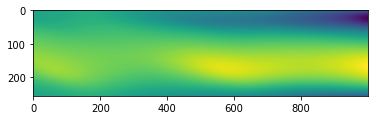

In [18]:
import numpy as np

from weight import *
from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    P = np.array(mat['P'])
    U = np.array(mat['U'])
    V = np.array(mat['V'])

# for some reason, we need to fix the order of the axes
P = np.transpose(P, (1, 2, 0))
U = np.transpose(U, (1, 2, 0))
V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
Nx = 256; Ny = Nx; Nt = 1000; # half resolution
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
#x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 0.2, dt)
#xg, yg = np.meshgrid(x, y)
#U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
#V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
#P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

0.027839316314777207

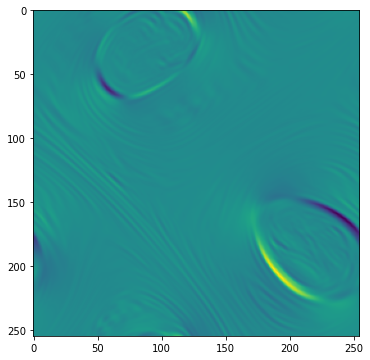

In [19]:
fig, ax= plt.subplots(figsize=(6,6))
dU = np.diff(U[:, :, -1], axis=0)
dV = np.diff(V[:, :, -1], axis=1)
ax.imshow(dU[:,1:]+dV[1:,:])
np.max(dU[:,1:]+dV[1:,:])

In [28]:
uobs = Observable('u', 1)
pobs = Observable('p', 0)

u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

### define all parameters and "make library"
terms = generate_terms_to(3, observables=[uobs, pobs], max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(U.shape)
m = 12
qmax = 1
nweights = qmax**2
ndomains = 30
wx = 64
wt = 50
pad = 0


In [29]:
#%%prun

# fix random seed
np.random.seed(1)

data_dict = {'p': P, 'u': u}

dxs = [dx, dy, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dx, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=True)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=True)#, by_parts=False)

***RANK 0 LIBRARY***

i: 0
UNINDEXED TERM:
1
TermSum 1
Value:  2972.4982987632147

i: 1
UNINDEXED TERM:
p
ORIGINAL TERM:
p [[0, 0, 0]]
INTEGRATED BY PARTS:
p [[0, 0, 0]] Weight([12, 12, 12], [0, 0, 0], [0, 0, 0], 1, [0.4921875, 0.4921875, 0.0245])
TermSum p
Value:  25295.258684876462

i: 2
UNINDEXED TERM:
dj^2 p
ORIGINAL TERM:
dx^2 p [[2, 0, 0]]
INTEGRATED BY PARTS:
p [[0, 0, 0]] Weight([12, 12, 12], [0, 0, 0], [2, 0, 0], 1, [0.4921875, 0.4921875, 0.0245])
TermSum p
ORIGINAL TERM:
dy^2 p [[0, 2, 0]]
INTEGRATED BY PARTS:
p [[0, 0, 0]] Weight([12, 12, 12], [0, 0, 0], [0, 2, 0], 1, [0.4921875, 0.4921875, 0.0245])
TermSum p
Value:  -44917.06321081314

i: 3
UNINDEXED TERM:
dt p
ORIGINAL TERM:
dt p [[0, 0, 1]]
INTEGRATED BY PARTS:
p [[0, 0, 0]] Weight([12, 12, 12], [0, 0, 0], [0, 0, 1], -1, [0.4921875, 0.4921875, 0.0245])
TermSum p
Value:  7514.212294125733

i: 4
UNINDEXED TERM:
dt^2 p
ORIGINAL TERM:
dt^2 p [[0, 0, 2]]
INTEGRATED BY PARTS:
p [[0, 0, 0]] Weight([12, 12, 12], [0, 0, 0], [0, 0,

In [30]:
#from sparse_reg import *
from ipynb.fs.full.sparse_reg import *
opts = dict()
#opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
opts['threshold'] = "'threshold'"
opts['n_terms'] = len(terms0)
opts['gamma'] = 1.5
opts['verbose'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts=opts, char_sizes=char_sizes0)

In [31]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 8] 1.0 * dj u_j
Model residual: 8.240729323952346e-13
One-term model residual: 8.240729323952346e-13
Best term (#8): dj u_j


In [32]:
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts=opts, char_sizes=char_sizes1)

In [33]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 3] 8.183948874387479e-11 * u_i
[Term 4] 1.0 * di dj u_j
Model residual: 3.724639456725844e-08
One-term model residual: 2.0226556483963e-07
Best term: di dj u_j


In [34]:
avoid = []
avoid.append(Xi)
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts=opts, char_sizes=char_sizes1, avoid=avoid)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 0] 0.999999974875463 * di p
[Term 5] -1.0026580429805397e-05 * dj^2 u_i
[Term 6] 0.9999998392169889 * dt u_i
[Term 13] 1.0 * dj u_i * u_j
Model residual: 2.4066874041978383e-06
One-term model residual: 8.941781891764255e-06
Best term: dj u_j * u_i


In [27]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)

1 1
p 11.909507841829365
dj^2 p 0.0020416148869192457
dt p 0.00836245457682123
dt^2 p 8.36245457682123e-06
p * p 141.83637703459513
dt p * p 0.0995927183595943
p * p * p 1689.2014445501773
dj u_j 0.036687726462512296
dt dj u_j 3.6687726462512294e-05
u_j * dj p 0.3638914456193968
dj u_j * p 0.4369327660041809
u_j * u_j 7.75596957879523
dt u_j * u_j 0.0065391126918544346
u_j * u_j * p 92.36978051965178
di p 0.13066335276283172
dt di p 0.00013066335276283171
di p * p 1.556136224368661
u_i 2.784954143032741
di dj u_j 0.0005732457259767546
dj^2 u_i 0.0005732457259767546
dt u_i 0.002348014493600787
dt^2 u_i 2.3480144936007867e-06
u_i * p 33.167433205583606
u_i * dt p 0.023289052519641393
dt u_i * p 0.027963697024267577
u_i * p * p 395.0078058552496
di u_j * u_j 0.10217363581022555
dj u_i * u_j 0.10217363581022555
dj u_j * u_i 0.10217363581022555
u_j * u_j * u_i 21.60001961170168
